In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from imblearn.combine import SMOTETomek

In [66]:
df = pd.read_csv('ddos.csv')
df = df.drop(['id', 'attack_cat'], axis=1)
numerical = df.select_dtypes(['int64', 'float64'])
categorical = df.select_dtypes('object')

In [67]:
encoder = LabelEncoder()
for i in categorical.columns:
    df[i] = encoder.fit_transform(df[i])

In [68]:
features = ['state', 'sttl', 'ct_state_ttl', 'dload', 'ct_dst_sport_ltm', 'rate', 'swin', 'dwin', 'dmean', 'ct_src_dport_ltm']
df['dload'] = np.log1p(df['dload'])
df['ct_dst_sport_ltm'] = np.log1p(df['ct_dst_sport_ltm'])
df['dmean'] = np.log1p(df['dmean'])

In [69]:
scaler = MinMaxScaler()
for i in features:
    df[i] = scaler.fit_transform(df[[i]])

In [70]:
x = df[features].values
y = df['label'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [71]:
xgb_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, scoring='f1_macro', cv=3, random_state=42, n_jobs=-1)

xgb_y_true = []
xgb_y_pred = []

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    smote = SMOTETomek(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    xgb_grid.fit(x_train_resampled, y_train_resampled)
    best_xgb = xgb_grid.best_estimator_

    probs = best_xgb.predict_proba(x_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_thresh = thresholds[np.argmax(f1_scores)]

    y_pred_thresh = (probs > best_thresh).astype(int)

    xgb_y_true.extend(y_test)
    xgb_y_pred.extend(y_pred_thresh)

print(classification_report(xgb_y_true, xgb_y_pred))

d:\ProgramData\library\environments\machine_learning\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:04:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ProgramData\library\environments\machine_learning\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ProgramData\library\environments\machine_learning\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:05:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ProgramData\library\environments\machine_learning\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:23] WARNING: C:\actions-runne

              precision    recall  f1-score   support

           0       0.97      0.83      0.90     56000
           1       0.93      0.99      0.96    119341

    accuracy                           0.94    175341
   macro avg       0.95      0.91      0.93    175341
weighted avg       0.94      0.94      0.94    175341



In [84]:
new_data = pd.read_csv("live_flows.csv")

new_data.head()

,src_ip,dst_ip,protocol,src_port,dst_port,state,sttl,ct_state_ttl,dload,ct_dst_sport_ltm,rate,swin,dwin,dmean,ct_src_dport_ltm
0,192.168.111.138,20.189.173.14,tcp,56202,443,SYN_SENT,128,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000
1,192.168.111.138,51.105.71.137,tcp,56173,443,ACK,128,0.0,0.000000e+00,0.000000,0.000000e+00,255.0,-1.0,172.000000,0.012131
2,192.168.111.138,51.105.71.137,tcp,56173,443,ACK,128,0.0,2.313222e+07,0.000071,2.313222e+07,255.0,-1.0,819.000000,0.000071
3,192.168.111.138,51.105.71.137,tcp,56173,443,ACK,128,0.0,3.798881e+07,0.000000,3.798881e+07,255.0,-1.0,896.666667,0.000000
4,20.189.173.14,192.168.111.138,tcp,443,56202,SYN_SENT,108,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000


In [85]:
numerical = new_data.select_dtypes(['int64', 'float64'])
numerical.head()

,src_port,dst_port,sttl,ct_state_ttl,dload,ct_dst_sport_ltm,rate,swin,dwin,dmean,ct_src_dport_ltm
0,56202,443,128,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000
1,56173,443,128,0.0,0.000000e+00,0.000000,0.000000e+00,255.0,-1.0,172.000000,0.012131
2,56173,443,128,0.0,2.313222e+07,0.000071,2.313222e+07,255.0,-1.0,819.000000,0.000071
3,56173,443,128,0.0,3.798881e+07,0.000000,3.798881e+07,255.0,-1.0,896.666667,0.000000
4,443,56202,108,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000


In [86]:
categorical = new_data.select_dtypes('object')
categorical.head()

,src_ip,dst_ip,protocol,state
0,192.168.111.138,20.189.173.14,tcp,SYN_SENT
1,192.168.111.138,51.105.71.137,tcp,ACK
2,192.168.111.138,51.105.71.137,tcp,ACK
3,192.168.111.138,51.105.71.137,tcp,ACK
4,20.189.173.14,192.168.111.138,tcp,SYN_SENT


In [87]:
encoder = LabelEncoder()
for i in categorical.columns:
    new_data[i] = encoder.fit_transform(new_data[i])

new_data.head()

,src_ip,dst_ip,protocol,src_port,dst_port,state,sttl,ct_state_ttl,dload,ct_dst_sport_ltm,rate,swin,dwin,dmean,ct_src_dport_ltm
0,13,13,0,56202,443,1,128,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000
1,13,31,0,56173,443,0,128,0.0,0.000000e+00,0.000000,0.000000e+00,255.0,-1.0,172.000000,0.012131
2,13,31,0,56173,443,0,128,0.0,2.313222e+07,0.000071,2.313222e+07,255.0,-1.0,819.000000,0.000071
3,13,31,0,56173,443,0,128,0.0,3.798881e+07,0.000000,3.798881e+07,255.0,-1.0,896.666667,0.000000
4,18,11,0,443,56202,1,108,0.0,0.000000e+00,0.000000,0.000000e+00,65535.0,0.0,66.000000,0.000000


In [88]:
scaler = MinMaxScaler()
for i in new_data.columns:
    new_data[i] = scaler.fit_transform(new_data[[i]])

new_data.head()

,src_ip,dst_ip,protocol,src_port,dst_port,state,sttl,ct_state_ttl,dload,ct_dst_sport_ltm,rate,swin,dwin,dmean,ct_src_dport_ltm
0,0.393939,0.342105,0.0,0.870244,0.006045,0.5,0.50000,0.0,0.000000,0.000000e+00,0.000000,1.000000,0.003891,0.008475,0.000000e+00
1,0.393939,0.815789,0.0,0.869794,0.006045,0.0,0.50000,0.0,0.000000,0.000000e+00,0.000000,0.003891,0.001946,0.083333,1.710967e-04
2,0.393939,0.815789,0.0,0.869794,0.006045,0.0,0.50000,0.0,0.554913,9.981806e-07,0.554913,0.003891,0.001946,0.540254,9.986977e-07
3,0.393939,0.815789,0.0,0.869794,0.006045,0.0,0.50000,0.0,0.911303,0.000000e+00,0.911303,0.003891,0.001946,0.595104,0.000000e+00
4,0.545455,0.289474,0.0,0.006045,0.870244,0.5,0.42126,0.0,0.000000,0.000000e+00,0.000000,1.000000,0.003891,0.008475,0.000000e+00


In [89]:
features = ['state', 'sttl', 'ct_state_ttl', 'dload', 'ct_dst_sport_ltm', 'rate', 'swin', 'dwin', 'dmean', 'ct_src_dport_ltm']
x = new_data[features]
# Set semua nilai kolom 'label' menjadi 0
new_data['label'] = 0

# Ambil kolom 'label' sebagai variabel y
y = new_data['label']

# y = new_data['label']
probs = xgb_grid.predict_proba(x)[:, 1]
y_pred = xgb_grid.predict(x)

In [92]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1073
           1       0.00      0.00      0.00         0

    accuracy                           0.97      1073
   macro avg       0.50      0.48      0.49      1073
weighted avg       1.00      0.97      0.98      1073



d:\ProgramData\library\environments\machine_learning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ProgramData\library\environments\machine_learning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ProgramData\library\environments\machine_learning\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

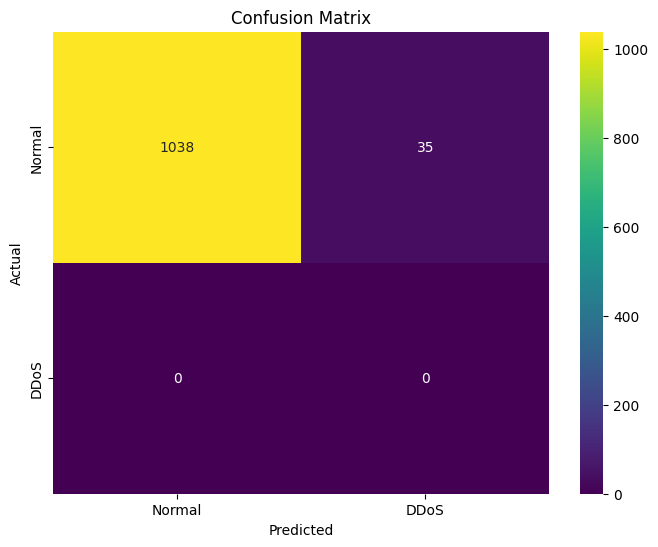

In [93]:
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [94]:
probs

array([0.00420115, 0.02643706, 0.5513873 , ..., 0.42179498, 0.02440425,
       0.00957403], shape=(1073,), dtype=float32)

In [95]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(1073,))

In [ ]:
import joblib
joblib.dump(xgb_model, 'model_xgb.pkl')

['model_xgb.pkl']